In [1]:
import torch

import numpy as np

from torch import nn
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
from tqdm import tqdm_notebook

from IPython.display import clear_output

In [2]:
transform=transforms.Compose([
        transforms.ToTensor(),
])# Иначе мы получим PIL изображения

dataset = datasets.MNIST('./data/', download=True, transform=transform)

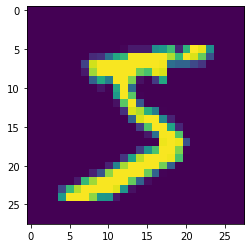

In [3]:
dataset[0]# image, class
plt.imshow(dataset[0][0].numpy()[0])

In [4]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
    def forward(self, x):
        return torch.reshape(x, (x.shape[0], *self.shape))

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(100, 7*7*256),
            nn.ELU(),
            Reshape((256, 7, 7)),
            
            nn.UpsamplingBilinear2d(scale_factor=2), # 14
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ELU(),
            
            nn.UpsamplingBilinear2d(scale_factor=2), # 28
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ELU(),
            
            nn.Conv2d(64, 1, 3, padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), #28
            nn.BatchNorm2d(16),
            nn.ELU(),
            
            nn.Conv2d(16, 32, 3, stride=2, padding=1), #14
            nn.BatchNorm2d(32),
            nn.ELU(),
            
            nn.Conv2d(32, 64, 3, stride=2, padding=1), #7
            nn.BatchNorm2d(64),
            nn.ELU(),
            
            nn.Conv2d(64, 1, 7), #1
        )
    def forward(self, x):
        return self.model(x)[:, 0, 0]

In [6]:
generator = Generator()
discriminator = Discriminator()

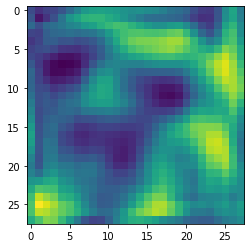

In [7]:
latent = torch.randn(1, 100)
output = generator(latent)

plt.imshow(output.detach().numpy()[0, 0])

In [8]:
discriminator(output)

[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


tensor([[0.2895]], grad_fn=<SelectBackward0>)

In [9]:
def discriminator_loss_fn(real_output, fake_output):
    real_loss = nn.BCEWithLogitsLoss()(real_output, torch.ones_like(real_output))
    fake_loss = nn.BCEWithLogitsLoss()(fake_output, torch.zeros_like(fake_output))
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss_fn(fake_output):
    fake_loss = nn.BCEWithLogitsLoss()(fake_output, torch.ones_like(fake_output))
    return fake_loss

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

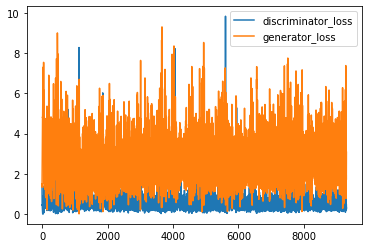

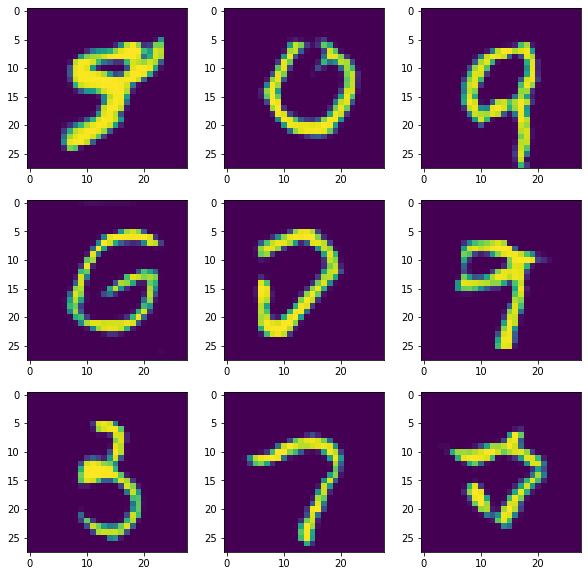

In [11]:
num_epoch = 5
batch_size = 32

real_loader = torch.utils.data.DataLoader(dataset, batch_size)

generator_optimizer = torch.optim.Adam(generator.parameters())
discriminator_optimizer = torch.optim.Adam(discriminator.parameters())

iteration = 0

d_loss_hist = []
g_loss_hist = []

for epoch in range(num_epoch):
    for real_batch, _ in real_loader:
        real_batch = real_batch.to(device)
        real_prediction = discriminator(real_batch)
        
        latent = torch.randn(batch_size, 100).to(device)
        fake_batch = generator(latent)
        fake_prediction = discriminator(fake_batch)
        
        discriminator.zero_grad()
        discriminator_loss = discriminator_loss_fn(real_prediction, fake_prediction)
        discriminator_loss.backward()
        d_loss_hist.append(discriminator_loss.detach().cpu().numpy())
        discriminator_optimizer.step()
        discriminator_optimizer.zero_grad()
        
        latent = torch.randn(batch_size, 100).to(device)
        fake_batch = generator(latent)
        fake_prediction = discriminator(fake_batch)
        
        generator.zero_grad()
        generator_loss = generator_loss_fn(fake_prediction)
        generator_loss.backward()
        g_loss_hist.append(generator_loss.detach().cpu().numpy())
        generator_optimizer.step()
        generator_optimizer.zero_grad()
       
        
        iteration += 1
        
        if iteration% 100 == 0:
            clear_output(wait=True)
            
            plt.plot(d_loss_hist, label='discriminator_loss')
            plt.plot(g_loss_hist, label='generator_loss')
            plt.legend()
            plt.show()
            fig, axis = plt.subplots(3, 3, figsize=[10, 10])
            for i in range(9):
                axis[i//3, i%3].imshow(fake_batch.cpu().detach().numpy()[i, 0])
            plt.show()
        
        
    

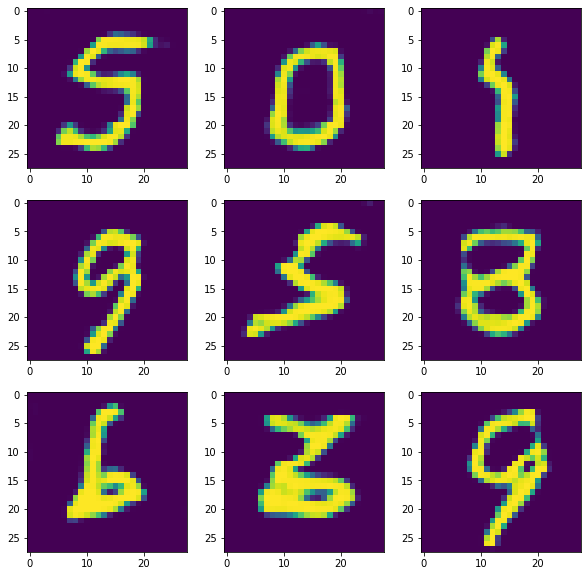

In [12]:
latent = torch.randn(9, 100).to(device)
fake_batch = generator(latent)

fig, axis = plt.subplots(3, 3, figsize=[10, 10])
for i in range(9):
    axis[i//3, i%3].imshow(fake_batch.cpu().detach().numpy()[i, 0])
plt.show()